In [1]:
# ============================================================================
# 1. SETUP AND CONFIGURATION
# ============================================================================

import os
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm.auto import tqdm
import warnings
import gc
import random
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
SAMPLE_SIZE = 2000
NUM_EPOCHS = 3

Using device: cuda


In [2]:
# ============================================================================
# 2. KAGGLE SETUP
# ============================================================================

kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

kaggle_json = {
    "username": "yassineyahyaouii",
    "key": "6e0ebf67d37bb1c91dc21f7861a27c77"
}

with open(os.path.join(kaggle_dir, "kaggle.json"), 'w') as f:
    json.dump(kaggle_json, f)
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

print("✓ Kaggle credentials configured")

# ============================================================================
# 3. DOWNLOAD AND EXTRACT DATASET
# ============================================================================

print("\n" + "="*60)
print("DOWNLOADING CELEBA DATASET")
print("="*60 + "\n")

!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip -q celeba-dataset.zip -d celeba_raw

print("✓ Dataset downloaded")

✓ Kaggle credentials configured

DOWNLOADING CELEBA DATASET

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 95% 1.26G/1.33G [00:08<00:00, 143MB/s]
100% 1.33G/1.33G [00:08<00:00, 174MB/s]
✓ Dataset downloaded


In [3]:
# ============================================================================
# 4. MEMORY-EFFICIENT EXTRACTION WITH SAMPLING
# ============================================================================

def extract_sampled_celeba(raw_dir, sample_size=None):
    """Extract CelebA with memory-efficient sampling"""

    output_dir = Path('celeba_sampled')
    output_dir.mkdir(exist_ok=True, parents=True)

    for split in ['train', 'val', 'test']:
        for gender in ['male', 'female']:
            (output_dir / split / gender).mkdir(exist_ok=True, parents=True)

    print("\n" + "="*60)
    print("EXTRACTING AND ORGANIZING DATASET")
    print("="*60 + "\n")

    # Load metadata
    raw_root = Path(raw_dir) / 'celeba_raw'
    df_part = pd.read_csv(raw_root / 'list_eval_partition.csv')
    df_attr = pd.read_csv(raw_root / 'list_attr_celeba.csv')
    df = df_part.merge(df_attr[['image_id', 'Male']], on='image_id')

    # Map partitions
    partition_map = {0: 'train', 1: 'val', 2: 'test'}
    df['split'] = df['partition'].map(partition_map)
    df['gender'] = df['Male'].apply(lambda x: 'male' if x == 1 else 'female')

    img_root = raw_root / 'img_align_celeba' / 'img_align_celeba'

    # Pre-classify by split and gender
    male_train = df[(df['split'] == 'train') & (df['gender'] == 'male')].reset_index(drop=True)
    female_train = df[(df['split'] == 'train') & (df['gender'] == 'female')].reset_index(drop=True)
    male_val = df[(df['split'] == 'val') & (df['gender'] == 'male')].reset_index(drop=True)
    female_val = df[(df['split'] == 'val') & (df['gender'] == 'female')].reset_index(drop=True)
    male_test = df[(df['split'] == 'test') & (df['gender'] == 'male')].reset_index(drop=True)
    female_test = df[(df['split'] == 'test') & (df['gender'] == 'female')].reset_index(drop=True)

    print(f"Found {len(male_train)} male train images")
    print(f"Found {len(female_train)} female train images")

    # Sample if needed
    if sample_size:
        train_per_gender = sample_size // 2
        val_per_gender = int(sample_size * 0.15)
        test_per_gender = int(sample_size * 0.15)

        male_train = male_train.sample(n=min(train_per_gender, len(male_train)), random_state=42)
        female_train = female_train.sample(n=min(train_per_gender, len(female_train)), random_state=42)
        male_val = male_val.sample(n=min(val_per_gender, len(male_val)), random_state=42)
        female_val = female_val.sample(n=min(val_per_gender, len(female_val)), random_state=42)
        male_test = male_test.sample(n=min(test_per_gender, len(male_test)), random_state=42)
        female_test = female_test.sample(n=min(test_per_gender, len(female_test)), random_state=42)

        print(f"Sampling {sample_size} images total")

    # Combine all samples
    samples = pd.concat([male_train, female_train, male_val, female_val, male_test, female_test])

    # Extract
    counts = {'train': {'male': 0, 'female': 0},
              'val': {'male': 0, 'female': 0},
              'test': {'male': 0, 'female': 0}}

    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Extracting images"):
        img_id = row['image_id']
        split = row['split']
        gender = row['gender']

        src = img_root / img_id
        if not src.exists():
            continue

        dst = output_dir / split / gender / img_id
        shutil.copy2(src, dst)
        counts[split][gender] += 1

    print(f"\n✓ Extraction complete:")
    print(f"  - Train: {counts['train']['male']} male, {counts['train']['female']} female")
    print(f"  - Val: {counts['val']['male']} male, {counts['val']['female']} female")
    print(f"  - Test: {counts['test']['male']} male, {counts['test']['female']} female")

    gc.collect()
    return output_dir

organized_dir = extract_sampled_celeba('.', sample_size=SAMPLE_SIZE)
split_dir = organized_dir


EXTRACTING AND ORGANIZING DATASET

Found 68261 male train images
Found 94509 female train images
Sampling 2000 images total


Extracting images:   0%|          | 0/3200 [00:00<?, ?it/s]


✓ Extraction complete:
  - Train: 1000 male, 1000 female
  - Val: 300 male, 300 female
  - Test: 300 male, 300 female


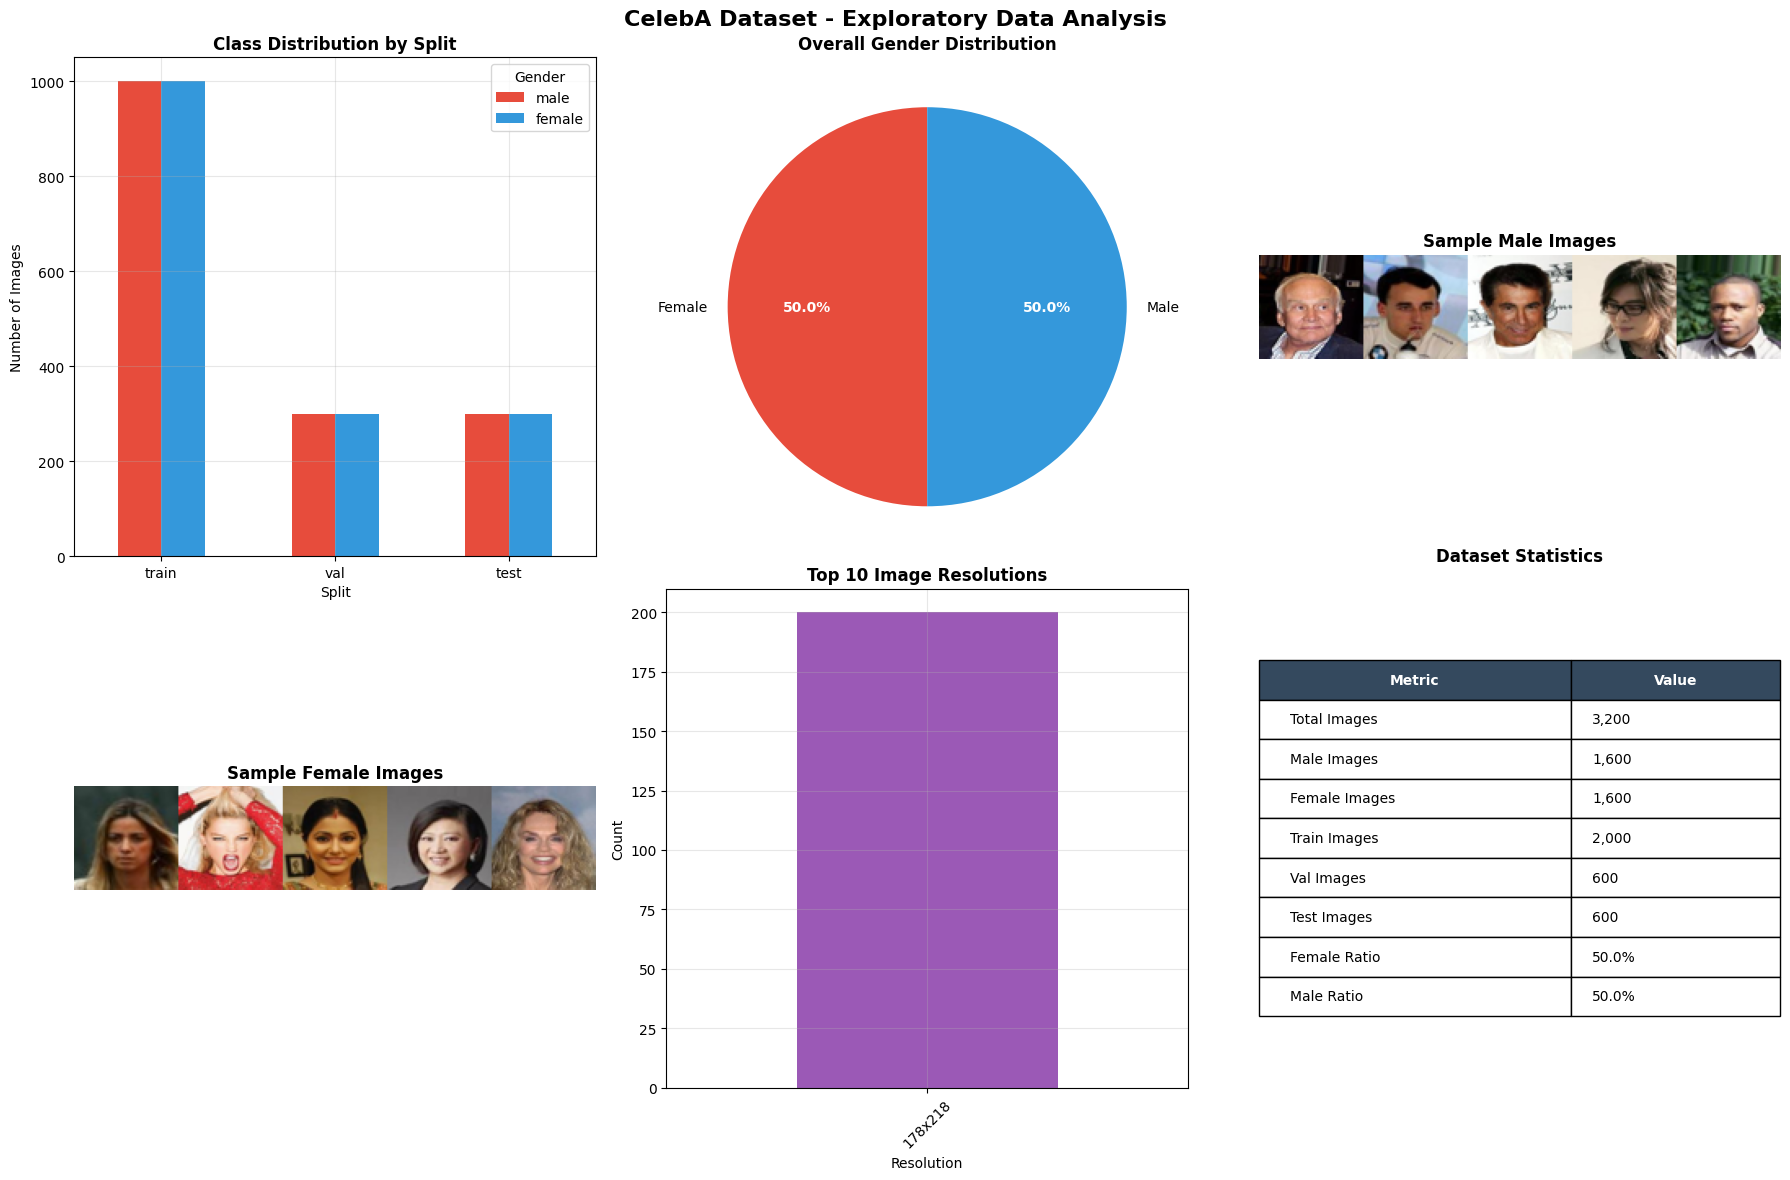

✓ EDA completed and saved to 'celeba_eda_analysis.png'


In [4]:
# ============================================================================
# 5. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

def perform_eda(split_dir):
    """Perform comprehensive EDA"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('CelebA Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

    # 1. Class Distribution
    counts = {'train': {}, 'val': {}, 'test': {}}
    for split in ['train', 'val', 'test']:
        for gender in ['male', 'female']:
            count = len(list((split_dir / split / gender).glob('*.jpg'))) + \
                    len(list((split_dir / split / gender).glob('*.jpeg'))) + \
                    len(list((split_dir / split / gender).glob('*.png')))
            counts[split][gender] = count

    ax = axes[0, 0]
    df_counts = pd.DataFrame(counts).T
    df_counts.plot(kind='bar', ax=ax, color=['#e74c3c', '#3498db'])
    ax.set_title('Class Distribution by Split', fontsize=12, fontweight='bold')
    ax.set_xlabel('Split')
    ax.set_ylabel('Number of Images')
    ax.legend(title='Gender')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

    # 2. Overall class balance
    ax = axes[0, 1]
    total_male = sum(counts[s]['male'] for s in counts)
    total_female = sum(counts[s]['female'] for s in counts)
    colors = ['#e74c3c', '#3498db']
    wedges, texts, autotexts = ax.pie([total_female, total_male],
                                       labels=['Female', 'Male'],
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax.set_title('Overall Gender Distribution', fontsize=12, fontweight='bold')

    # 3. Sample images - Male
    ax = axes[0, 2]
    male_imgs = list((split_dir / 'train' / 'male').glob('*.jpg'))[:5]
    if male_imgs:
        combined = np.hstack([np.array(Image.open(img).resize((64, 64))) for img in male_imgs[:5]])
        ax.imshow(combined)
        ax.set_title('Sample Male Images', fontsize=12, fontweight='bold')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No male images', ha='center', va='center')
        ax.axis('off')

    # 4. Sample images - Female
    ax = axes[1, 0]
    female_imgs = list((split_dir / 'train' / 'female').glob('*.jpg'))[:5]
    if female_imgs:
        combined = np.hstack([np.array(Image.open(img).resize((64, 64))) for img in female_imgs[:5]])
        ax.imshow(combined)
        ax.set_title('Sample Female Images', fontsize=12, fontweight='bold')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No female images', ha='center', va='center')
        ax.axis('off')

    # 5. Image resolution analysis
    ax = axes[1, 1]
    resolutions = []
    for gender in ['male', 'female']:
        imgs = list((split_dir / 'train' / gender).glob('*.jpg'))[:100]
        for img_path in imgs:
            try:
                img = Image.open(img_path)
                resolutions.append(f"{img.size[0]}x{img.size[1]}")
            except:
                continue

    if resolutions:
        res_counts = pd.Series(resolutions).value_counts().head(10)
        res_counts.plot(kind='bar', ax=ax, color='#9b59b6')
        ax.set_title('Top 10 Image Resolutions', fontsize=12, fontweight='bold')
        ax.set_xlabel('Resolution')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

    # 6. Statistics table
    ax = axes[1, 2]
    ax.axis('off')
    total_images = total_male + total_female
    stats_data = [
        ['Total Images', f"{total_images:,}"],
        ['Male Images', f"{total_male:,}"],
        ['Female Images', f"{total_female:,}"],
        ['Train Images', f"{sum(counts['train'].values()):,}"],
        ['Val Images', f"{sum(counts['val'].values()):,}"],
        ['Test Images', f"{sum(counts['test'].values()):,}"],
        ['Female Ratio', f"{(total_female/total_images)*100:.1f}%"],
        ['Male Ratio', f"{(total_male/total_images)*100:.1f}%"]
    ]
    table = ax.table(cellText=stats_data, colLabels=['Metric', 'Value'],
                     cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    for i in range(2):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    ax.set_title('Dataset Statistics', fontsize=12, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('celeba_eda_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ EDA completed and saved to 'celeba_eda_analysis.png'")
    gc.collect()

perform_eda(split_dir)

In [5]:
# ============================================================================
# 6. DATASET AND DATALOADER
# ============================================================================

class GenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        for gender_idx, gender in enumerate(['female', 'male']):
            gender_dir = self.root_dir / gender
            if not gender_dir.exists():
                continue

            for ext in ['*.jpg', '*.jpeg', '*.png']:
                for img_path in gender_dir.glob(ext):
                    self.samples.append((str(img_path), gender_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            if self.transform:
                black_img = Image.new('RGB', (224, 224), color='black')
                return self.transform(black_img), label
            else:
                return torch.zeros(3, 224, 224), label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("\n" + "="*60)
print("CREATING DATASETS AND DATALOADERS")
print("="*60 + "\n")

train_dataset = GenderDataset(split_dir / 'train', transform=train_transform)
val_dataset = GenderDataset(split_dir / 'val', transform=test_transform)
test_dataset = GenderDataset(split_dir / 'test', transform=test_transform)

print(f"✓ Datasets created:")
print(f"  - Train: {len(train_dataset)} samples")
print(f"  - Val: {len(val_dataset)} samples")
print(f"  - Test: {len(test_dataset)} samples")

batch_size = 32
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, pin_memory=True,
                         persistent_workers=True if num_workers > 0 else False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=num_workers, pin_memory=True,
                       persistent_workers=True if num_workers > 0 else False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True,
                        persistent_workers=True if num_workers > 0 else False)

print("✓ DataLoaders created")
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


CREATING DATASETS AND DATALOADERS

✓ Datasets created:
  - Train: 2000 samples
  - Val: 600 samples
  - Test: 600 samples
✓ DataLoaders created


In [6]:
# ============================================================================
# 7. MODEL DEFINITION
# ============================================================================

class GenderClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(GenderClassifier, self).__init__()
        self.backbone = models.resnet18(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 2)
        )

    def forward(self, x):
        return self.backbone(x)

model = GenderClassifier(pretrained=True).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n✓ Model created (ResNet18)")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]



✓ Model created (ResNet18)
  - Total parameters: 11,177,538
  - Trainable parameters: 11,177,538


In [7]:
# ============================================================================
# 8. TRAINING
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                         'acc': f'{100.*correct/total:.2f}%'})

        if total % 1000 == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  patience=3, factor=0.5)

best_val_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_celeba.pth')
        print(f"✓ Model saved (Val Acc: {val_acc:.2f}%)")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%\n")



STARTING TRAINING


Epoch 1/3
----------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.3422 | Train Acc: 86.15%
Val Loss: 0.1994 | Val Acc: 93.17%
✓ Model saved (Val Acc: 93.17%)

Epoch 2/3
----------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1659 | Train Acc: 92.85%
Val Loss: 0.4669 | Val Acc: 84.33%

Epoch 3/3
----------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1461 | Train Acc: 94.20%
Val Loss: 0.1037 | Val Acc: 95.83%
✓ Model saved (Val Acc: 95.83%)

TRAINING COMPLETED
Best Validation Accuracy: 95.83%



In [8]:
# ============================================================================
# 9. EVALUATION
# ============================================================================

def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating', leave=False):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

model.load_state_dict(torch.load('best_model_celeba.pth'))
print("Evaluating on test set...")
test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device)

gc.collect()


Evaluating on test set...


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

39

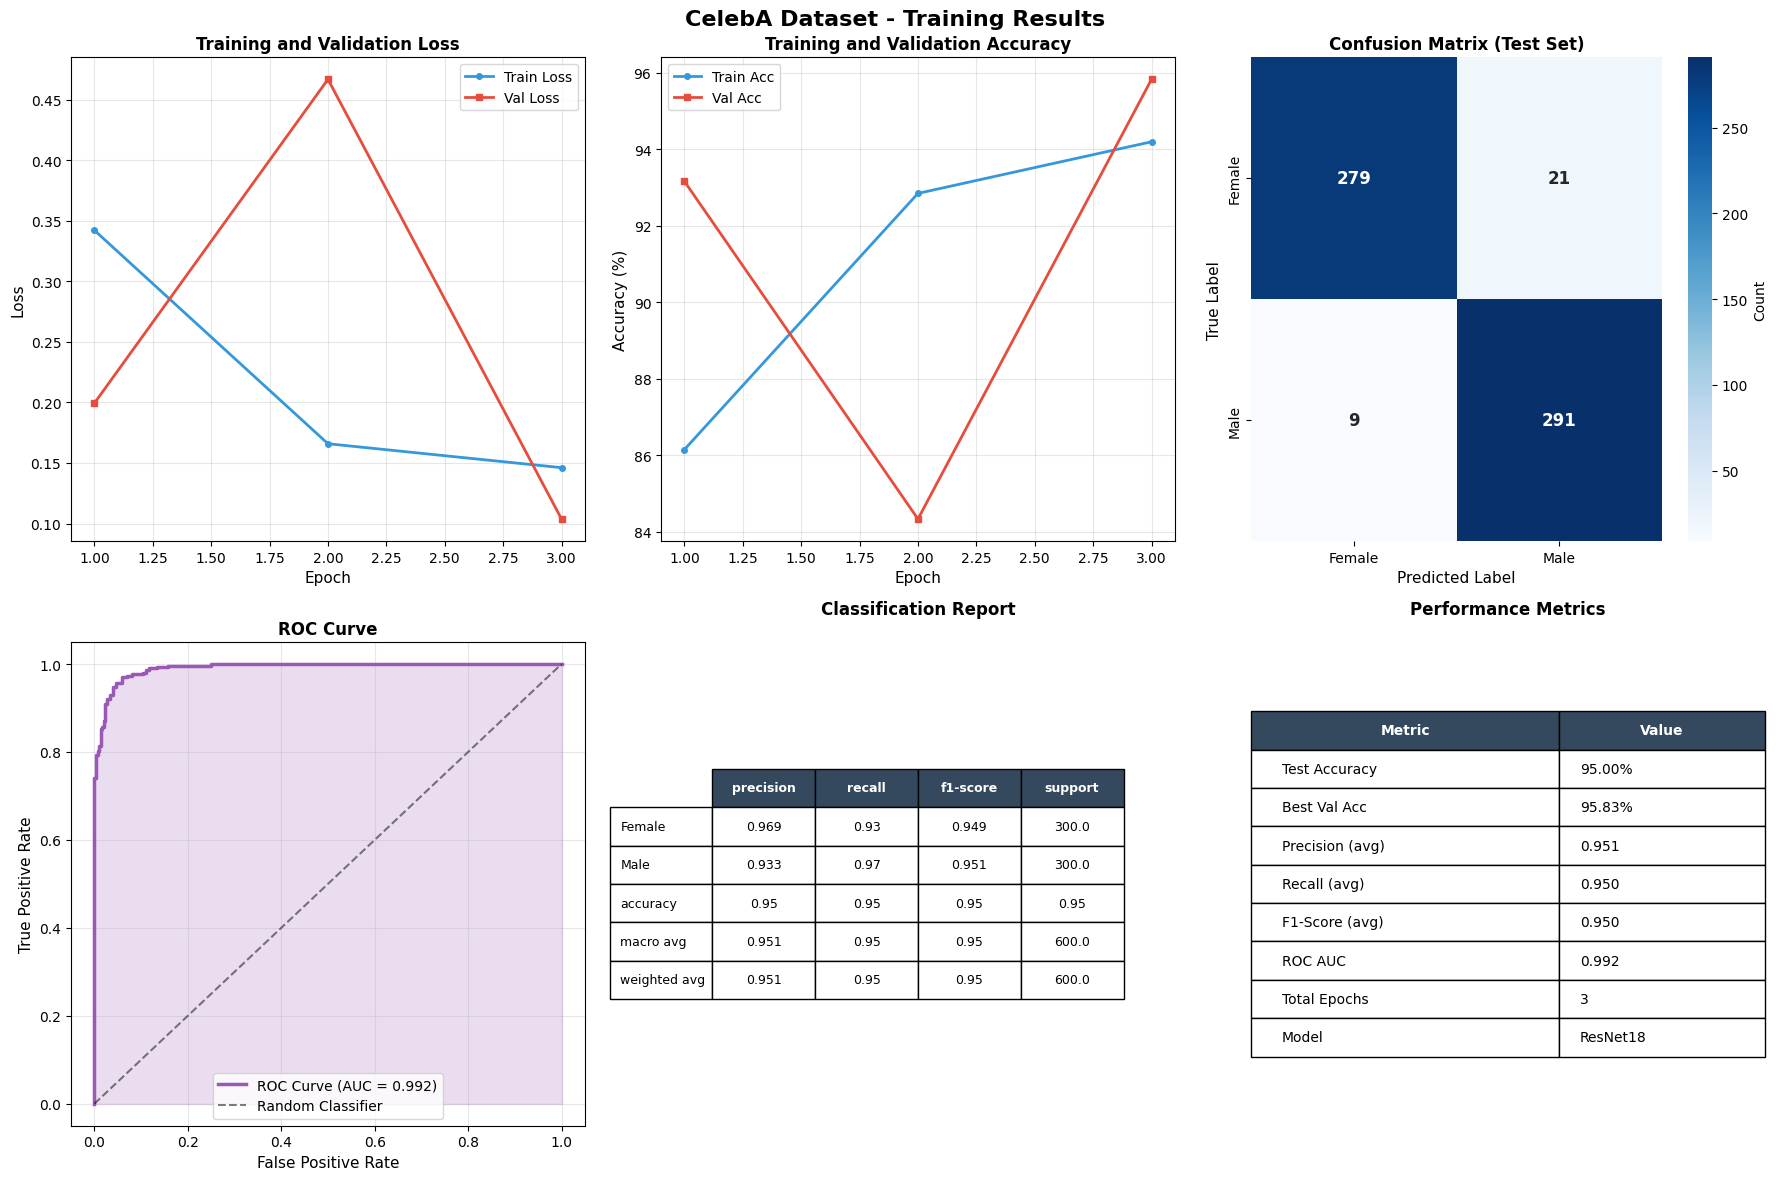

✓ Results visualization saved to 'celeba_training_results.png'


In [9]:
# ============================================================================
# 10. RESULTS VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('CelebA Dataset - Training Results', fontsize=16, fontweight='bold')

# 1. Training and Validation Loss
ax = axes[0, 0]
epochs_range = range(1, len(history['train_loss']) + 1)
ax.plot(epochs_range, history['train_loss'], label='Train Loss', linewidth=2,
        color='#3498db', marker='o', markersize=4)
ax.plot(epochs_range, history['val_loss'], label='Val Loss', linewidth=2,
        color='#e74c3c', marker='s', markersize=4)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Training and Validation Accuracy
ax = axes[0, 1]
ax.plot(epochs_range, history['train_acc'], label='Train Acc', linewidth=2,
        color='#3498db', marker='o', markersize=4)
ax.plot(epochs_range, history['val_acc'], label='Val Acc', linewidth=2,
        color='#e74c3c', marker='s', markersize=4)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Confusion Matrix
ax = axes[0, 2]
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'],
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)

# 4. ROC Curve
ax = axes[1, 0]
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, linewidth=2.5, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='#9b59b6')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.5)
ax.fill_between(fpr, tpr, alpha=0.2, color='#9b59b6')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 5. Classification Report
ax = axes[1, 1]
ax.axis('off')
report = classification_report(test_labels, test_preds,
                               target_names=['Female', 'Male'],
                               output_dict=True)
report_df = pd.DataFrame(report).T.round(3)
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
table = ax.table(cellText=report_df.values, colLabels=report_df.columns,
                 rowLabels=report_df.index, cellLoc='center', loc='center',
                 colWidths=[0.2, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(len(report_df.columns)):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax.set_title('Classification Report', fontsize=12, fontweight='bold', pad=20)

# 6. Performance Metrics Summary
ax = axes[1, 2]
ax.axis('off')
test_acc = 100 * (test_preds == test_labels).mean()
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

metrics_data = [
    ['Test Accuracy', f'{test_acc:.2f}%'],
    ['Best Val Acc', f'{best_val_acc:.2f}%'],
    ['Precision (avg)', f'{precision:.3f}'],
    ['Recall (avg)', f'{recall:.3f}'],
    ['F1-Score (avg)', f'{f1:.3f}'],
    ['ROC AUC', f'{roc_auc:.3f}'],
    ['Total Epochs', str(NUM_EPOCHS)],
    ['Model', 'ResNet18']
]
table = ax.table(cellText=metrics_data, colLabels=['Metric', 'Value'],
                 cellLoc='left', loc='center', colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for i in range(2):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax.set_title('Performance Metrics', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('celeba_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Results visualization saved to 'celeba_training_results.png'")